In [1]:
import sys
sys.path.append('../modules/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
import scipy
sns.set_style('white')
from collections import defaultdict
import matplotlib
import figures as fg
import general_figures as gn
import statsmodels.api as sm
from itertools import repeat
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib as mpl
import math
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['pdf.fonttype'] = 42


In [2]:
by_facs = {'Gal4':{'Full':3.31, 'Gal4AD': 3.341, 'Gcn4AD': 3.341},
          'Gcn4':{'Full': 3.27, 'Gal4AD': 3.32 , 'Gcn4AD': 3.32 },
          'Mig3':{'Full':3.26, 'Gal4AD':3.32 , 'Gcn4AD': 3.32 },
          'Yap1':{'Full':3.31, 'Gal4AD':3.3 , 'Gcn4AD':3.3 },
          'Msn2':{'Full':3.592, 'Gal4AD':3.62 , 'Gcn4AD':3.62 },}
by_facs_df = pd.DataFrame(by_facs)


In [3]:
data = pd.read_pickle('../data/averaged_chec_sumprom.gz')
TFS = ['Msn2', 'Gal4', 'Gcn4', 'Yap1', 'Mig3']
all_tfs = ['Vhr1',
 'Nrg2',
 'Pdr8',
 'Abf1',
 'Crz1',
 'Gln3',
 'Reb1',
 'Met31',
 'Rpn4',
 'Sko1',
 'Cst6']
gp = pd.read_csv('../data/geneinfo_params.csv', index_col=0)
aro_targets = np.array([1302,6541,4730,4729,2603,2604])
aro_targets = gp.iloc[aro_targets-1].index
data_check = data.rename(columns={'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr': 'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr',
                                     'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr':'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr'})
data_waro = data
data_waro= data_waro.rename(columns={'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr': 'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr',
                                     'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr':'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr'})
data_check = data.drop(aro_targets)

nuc_df = pd.read_csv('../data/nucleosomes_df_perprom700bp.csv', index_col=0)
rna_nonlibs = pd.read_pickle('../data/all_nonlibs_rna_samles.gz')
rna_libs = pd.read_pickle('../data/all_libs_rna_samles.gz').clip(0)
facs = pd.read_pickle('../data/all_libs_rna_samles.gz').clip(0).loc['facs']
by_rna = pd.read_csv('../data/by_ultimate_61samples.csv', index_col=0)
by_rna_median = pd.DataFrame(by_rna.median(axis=1), columns=['BY_61_med'])

# Binning and filtering genes
all_dat = pd.concat([rna_libs.drop('facs'), rna_nonlibs], axis=1)
gene_thresh = 4.5
strain_thsh = 0.025
for_binnning = ((all_dat > gene_thresh).sum(axis=1) > all_dat.shape[1] * strain_thsh).values
bins = pd.qcut(by_rna_median.loc[for_binnning, 'BY_61_med'], q=10, labels=False, duplicates='drop')
data_waro = data_waro.loc[bins.drop('MNASE').index]


#Looking only on relevant genes
rna_nonlibs = rna_nonlibs.loc[bins.index]
rna_libs = rna_libs.loc[bins.index]
by_rna_median = by_rna_median.loc[bins.index]
rna_libs = pd.concat([rna_libs,pd.DataFrame(facs).transpose()], axis=0)
data_check = data_check.loc[bins.drop(['MNASE', 'SPL2', 'NAF1', 'ESBP6', 'SDH6']).index]

rna_libs.columns = [name.replace('Parent', 'nativeprom') for name in rna_libs.columns.values]
facs.index = [name.replace('Parent', 'nativeprom') for name in facs.index.values]
opn = pd.read_csv('../data/external_datasets/opn_mine.csv', index_col=0)
opn.loc[np.isinf(opn.loc[:, 'opn_score']).values, 'opn_score'] = math.nan

opn = opn.loc[data_waro.index]
opn_index = opn.query('opn_score>0').index
dpn_index = opn.query('opn_score<=0').index
gray_index = opn.drop(np.concatenate((opn_index, dpn_index))).index
opn_bins = pd.qcut(opn.loc[:, 'opn_score'].values, 5, retbins=False, labels=False)
opn.loc[:, 'bins'] = opn_bins
opn.loc[:, 'bins'] = opn.loc[:, 'bins'].fillna(5)

In [4]:
thresh = 3
reload(fg)

binding_gcn4, rna_gcn4, top50_gcn4, fam_gcn4, wt_gcn4 = fg.get_data('Gcn4', data_check=data_check, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_gal4, rna_gal4, top50_gal4, fam_gal4, wt_gal4 = fg.get_data('Gal4', data_check=data_check, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_yap1, rna_yap1, top50_yap1, fam_yap1, wt_yap1 = fg.get_data('Yap1', data_check=data_check, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_msn2, rna_msn2, top50_msn2, fam_msn2, wt_msn2 = fg.get_data('Msn2', data_check=data_check, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_mig3, rna_mig3, top50_mig3, fam_mig3, wt_mig3 = fg.get_data('Mig3', data_check=data_check, rna_nonlibs=rna_nonlibs, thresh=thresh)



cmap = matplotlib.cm.get_cmap('YlOrRd')
tops = {'Msn2':top50_msn2, 'Gal4':top50_gal4, 'Gcn4':top50_gcn4, 'Mig3':top50_mig3, 'Yap1':top50_yap1}
individuals = {'Msn2':['TPS2', 'HOR7'], 'Gal4':['GAL10', 'GAL7'], 'Gcn4':['ARG56', 'CPA2'], 'Mig3':['HXT2', 'MIG2'], 'Yap1':['TRX2', 'YDL124W']}
wts = {'Msn2':wt_msn2, 'Gal4':wt_gal4, 'Gcn4':wt_gcn4, 'Mig3':wt_mig3, 'Yap1':wt_yap1}

In [5]:
all_tfs = ['Vhr1',
 'Nrg2',
 'Pdr8',
 'Yap1',
 'Mig3',
 'Dot6',
 'Abf1',
 'Crz1',
 'Gal4',
 'Gln3',
 'Reb1',
 'Msn2',
 'Met31',
 'Rpn4',
 'Sko1',
 'Ino2',
 'Gcn4',
 'Cst6']

lab_dat = data_waro.filter(regex='|'.join(all_tfs)).filter(regex='lab_data')
lab_dat = lab_dat.drop(lab_dat.filter(regex='dbd').columns, axis=1)
lab_dat = lab_dat.drop('Gal4_lab_data', axis=1)
lab_dat.loc[:, 'Gal4'] = data_check.filter(regex='^Gal4Full').filter(regex='erv')
lab_dat = lab_dat.rename({'Gcn4_lown_lab_data': 'Gcn4_lab_data'}, axis=1)

lab_dat.columns = [name.replace('_lab_data', '') for name in lab_dat.columns.values]


tfs_binding_deletions_tef = data_waro.filter(regex=''.join(['^{}|'.format(tf) for tf in TFS])[:-1]).filter(regex='deletions')
tfs_binding_deletions_tef = pd.concat([lab_dat.filter(regex=''.join(['^{}|'.format(tf) for tf in TFS])[:-1]), tfs_binding_deletions_tef], axis=1)

In [6]:
nonlibs_tef_data = [fg.get_nonlib_data(tf,rna_nonlibs, data_waro, 'nodeletion_tef') for tf in all_tfs]
nonlibs_tef_rna = pd.concat([data[1] for data in nonlibs_tef_data], axis=1).sub(by_rna_median.values, axis=0).loc[bins.index]
nonlibs_tef_rna = pd.concat([nonlibs_tef_rna.filter(regex=i) for i in ['Full', 'Gal4AD', 'Gcn4AD']], axis=1)
nonlibs_tef_binding = pd.concat([data[0] for data in nonlibs_tef_data], axis=1)

nonlibs_tef_binding = pd.concat([data_waro.loc[:, 'Rpn4Full_dRpn4_deletions_tef_3_reps_0.95_meancorr'], nonlibs_tef_binding, ], axis=1)


In [7]:
ordered_df = pd.concat([tfs_binding_deletions_tef.filter(regex='^{}'.format(i)) for i in TFS], axis=1)
ordered_df.columns = ['_'.join(k.split('_')[0:2]) for k in ordered_df.columns.values]

In [8]:
rna_libs = rna_libs.loc[:, rna_libs.columns[::-1]]

In [9]:
# rna_libs.sub(rna_libs.median(axis=1), axis=0).corr().to_csv('data_for_matlab_corr.csv')

In [10]:
# fig ,ax = plt.subplots(1)
to_plot = pd.DataFrame()
for tf in ['Gal4','Gcn4','Yap1','Msn2', 'Mig3',  ]:
    for stype in ['Full', 'Gal4AD', 'Gcn4AD']:
        to_plot = pd.concat([to_plot, rna_libs.filter(regex='^{}'.format(tf)).filter(regex=stype)], axis=1)
# sns.heatmap(to_plot.sub(to_plot.median(axis=1), axis=0).corr(), cmap='RdYlGn', center=0, vmax=0.45, vmin=-0.2, xticklabels=False, yticklabels=False, ax=ax)


# cmsm = []
# for tf in ['Gcn4', 'Mig3', 'Gal4', 'Msn2', 'Yap1']:
#     for stype in ['Full', 'Gal4AD', 'Gcn4AD']:
#         cmsm.append(rna_libs.filter(regex='^{}'.format(tf)).filter(regex=stype).shape[1])
# for num in np.cumsum(cmsm):
#     ax.axvline(num, c ='k', linewidth=0.5)
#     ax.axhline(num, c ='k', linewidth=0.5)
# for num,tf in zip([60,180,300,420,540],['Gcn4', 'Mig3', 'Gal4', 'Msn2', 'Yap1']):
#     ax.text(-200,num,tf)
# for num, stype in zip(range(0,600,40),['Full', 'Gcn4AD', 'Gal4AD']*5):
#     ax.text(-100, num, stype)
# fig.savefig('../figures_finalized/supp/mrnacorr.eps', bbox_inches = 'tight')

In [11]:
to_plot.sub(to_plot.median(axis=1), axis=0).corr().to_csv('data_for_matlab_corr.csv')

In [12]:
cmsm = []
for tf in ['Gal4','Gcn4','Yap1','Msn2', 'Mig3',  ]:
    for stype in ['Full', 'Gal4AD', 'Gcn4AD']:
        cmsm.append(rna_libs.filter(regex='^{}'.format(tf)).filter(regex=stype).shape[1])
print(np.cumsum(cmsm))

[ 41  83 124 164 205 241 282 324 366 407 447 488 517 560 601]


# Promss

In [34]:
corr_tfs = ['Vhr1',
 'Nrg2',
 'Pdr8',
 'Abf1',
 'Crz1',
 'Gln3',
 'Reb1',
 'Met31',
 'Rpn4',
 'Sko1',
 'Cst6']
def convert_name(tf, name):
    if 'Full' in name:
        return '{} O.E.'.format(tf)
    elif 'Gal4AD' in name:
        return 'DBD{} ADGal4'.format(tf)
    elif 'Gcn4AD' in name:
        return 'DBD{} ADGcn4'.format(tf)
    else:
        return tf

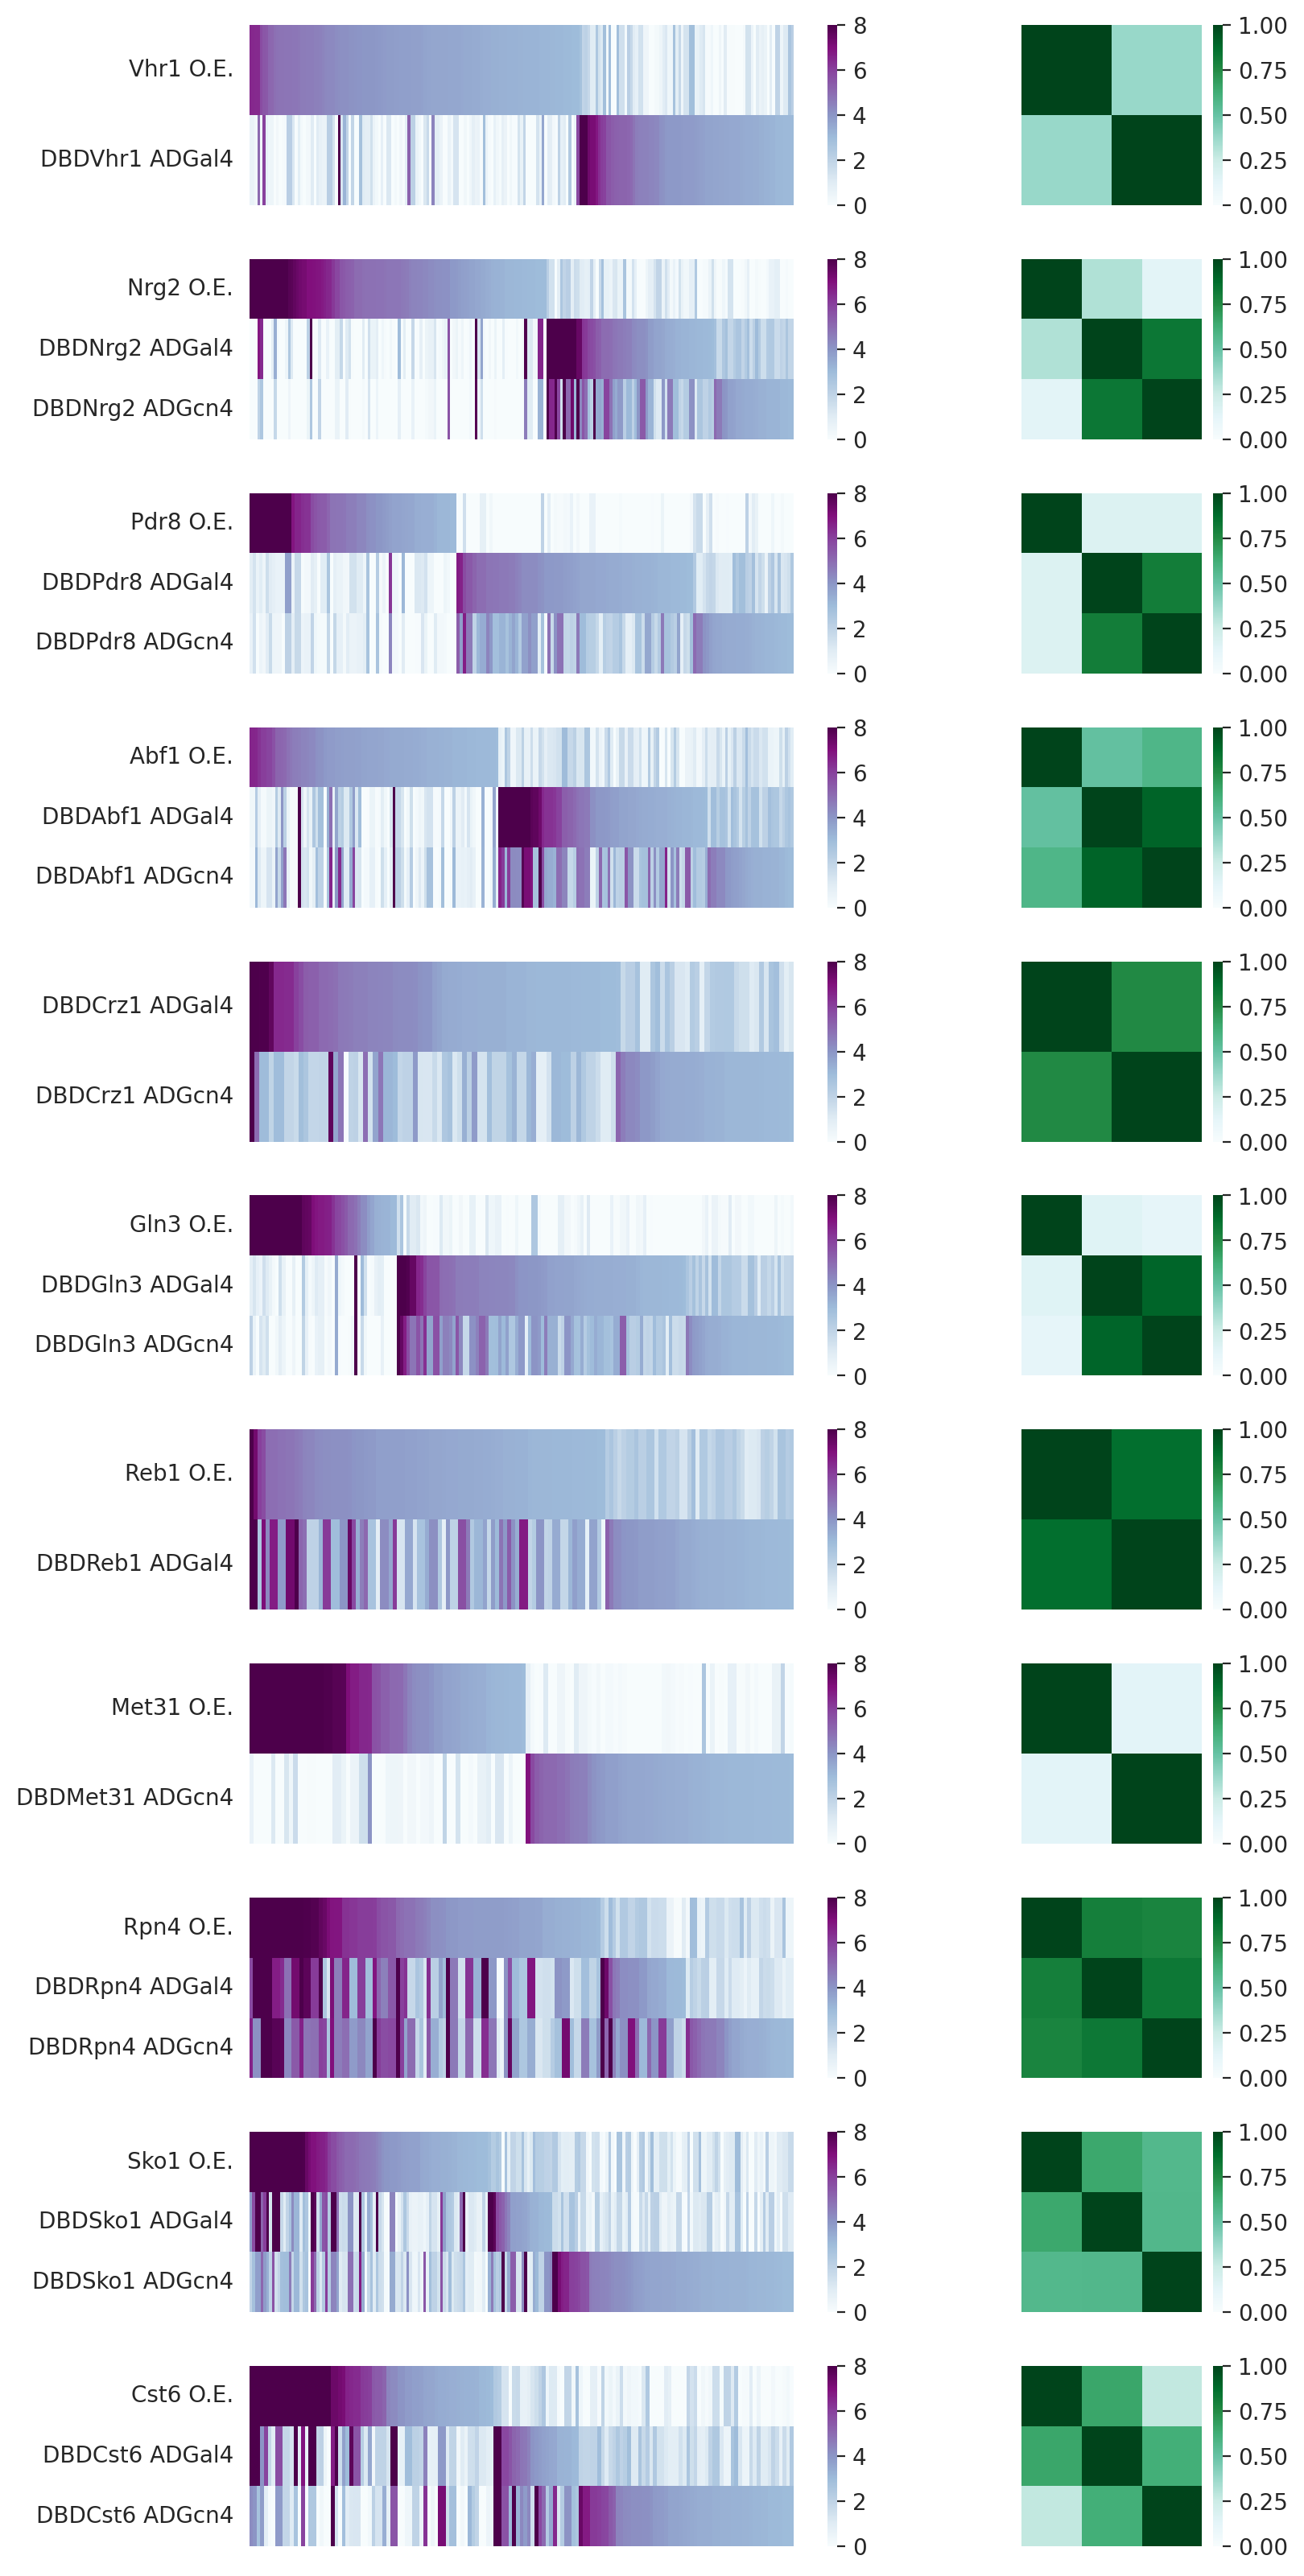

In [35]:
reload(fg)
fig = plt.figure(figsize=(8,16))
sf = fig.subfigures(len(corr_tfs), 1)
for k, tf in enumerate(corr_tfs):
    targets_df = fg.get_targets_df(nonlibs_tef_binding.filter(regex='^{}'.format(tf)), 3, 'new', opn, '')
    vector_ts = pd.Index(np.concatenate(np.concatenate(targets_df.values))).drop_duplicates()
    dat = gn.get_zscored(nonlibs_tef_binding).filter(regex='^{}'.format(tf)).loc[vector_ts].copy()
    ytickl = [convert_name(tf, name) for name in nonlibs_tef_binding.filter(regex='^{}'.format(tf)).columns.values]
    
    ax = sf[k].subplots(1,2, sharey=True, width_ratios=[3,1])
    sns.heatmap(dat.transpose(),yticklabels = ytickl,
                xticklabels=False, vmax=8, vmin=0, cmap='BuPu', ax=ax[0])
    sns.heatmap(nonlibs_tef_binding.filter(regex='^{}'.format(tf)).corr(),
            cmap='BuGn',yticklabels = ytickl,
            ax=ax[1], square=True, vmax=1, vmin=0, xticklabels=False)
# fig.savefig('../after_gm/fig4/proms_nondel_heats_corrs.pdf', bbox_inches = 'tight')

In [36]:
all_tfs = ['Vhr1',
 'Nrg2',
 'Pdr8',
 'Abf1',
 'Crz1',
 'Gln3',
 'Reb1',
 'Met31',
 'Rpn4',
 'Sko1',
 'Cst6']

In [41]:
all_tfsbs_tef_binding = pd.concat([nonlibs_tef_binding.filter(regex='DBD').filter(regex='^'+tf) for tf in all_tfs], axis=1)

cmsm = []
for tf in all_tfs:
    cmsm.append(nonlibs_tef_binding.filter(regex='DBD').filter(regex='^'+tf).shape[1])

In [42]:

all_tfsbs_tef_binding.columns = [convert_name(name[:4],name) for name in all_tfsbs_tef_binding.columns.values]

In [43]:
all_tfsbs_tef_binding = pd.concat([all_tfsbs_tef_binding.filter(regex='ADGal4'),
                                   all_tfsbs_tef_binding.filter(regex='ADGcn4')], axis=1)

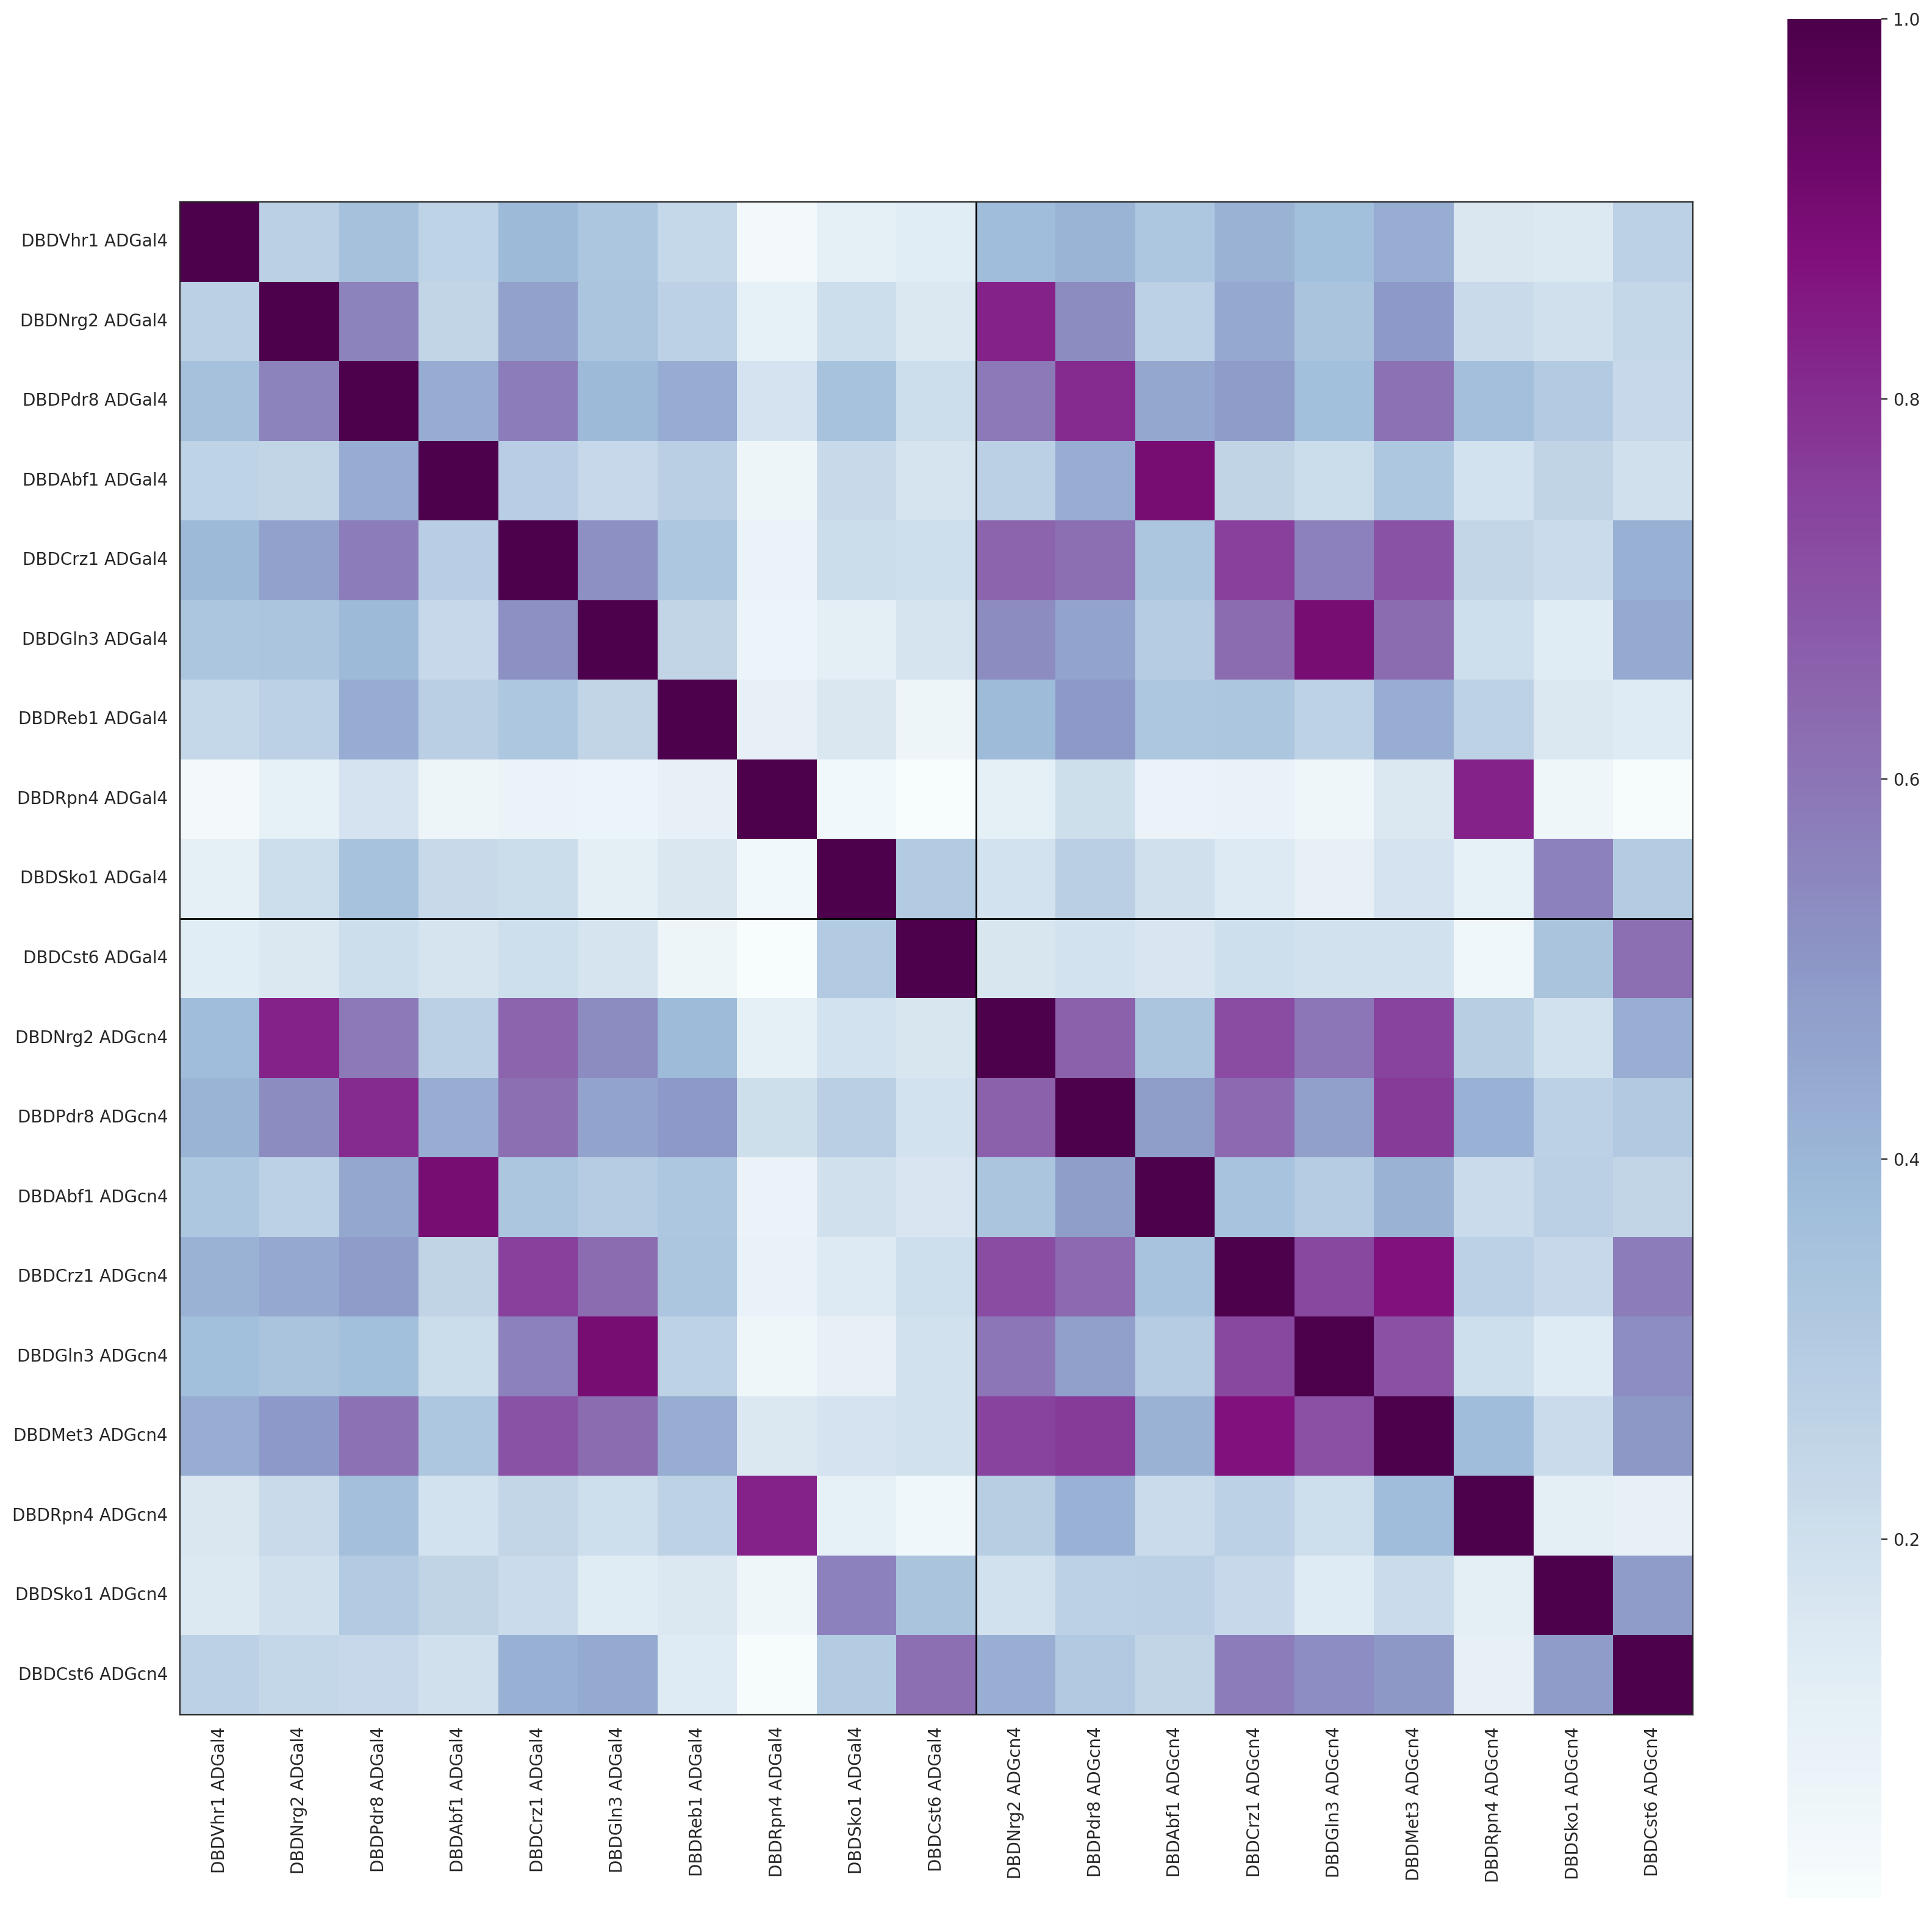

In [46]:
fig,ax = plt.subplots(1, figsize=(20,20))
d = sns.heatmap(all_tfsbs_tef_binding.corr(),
            cmap= 'BuPu', ax=ax, square=True)
ax.axvline(all_tfsbs_tef_binding.filter(regex='ADGal4').shape[1],c='k', linewidth=1)
ax.axhline(all_tfsbs_tef_binding.filter(regex='ADGcn4').shape[1],c='k', linewidth=1)
for _, spine in d.spines.items():
        spine.set_visible(True)
fig.savefig('biggcorr_nodel_dbdonly.pdf', bbox_inches = 'tight')